In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression

# Set plot style
sns.set_style("whitegrid")

# Load the data
df_payrolls = pd.read_csv('mlb_payrolls.csv')
df_batting = pd.read_csv('mlb_2011_2025_batting_selenium.csv')

# Dictionary for mapping full team names in the batting data to the 3-letter codes in the payroll data
team_mapping = {
    'Arizona Diamondbacks': 'ARI', 'Atlanta Braves': 'ATL', 'Baltimore Orioles': 'BAL',
    'Boston Red Sox': 'BOS', 'Chicago Cubs': 'CHC', 'Chicago White Sox': 'CHW',
    'Cincinnati Reds': 'CIN', 'Cleveland Indians': 'CLE', 'Cleveland Guardians': 'CLE',
    'Colorado Rockies': 'COL', 'Detroit Tigers': 'DET', 'Florida Marlins': 'MIA',
    'Miami Marlins': 'MIA', 'Houston Astros': 'HOU', 'Kansas City Royals': 'KC',
    'Los Angeles Angels of Anaheim': 'LAA', 'Los Angeles Angels': 'LAA',
    'Los Angeles Dodgers': 'LAD', 'Milwaukee Brewers': 'MIL', 'Minnesota Twins': 'MIN',
    'New York Mets': 'NYM', 'New York Yankees': 'NYY', 'Oakland Athletics': 'OAK',
    'Athletics': 'OAK', 'Philadelphia Phillies': 'PHI', 'Pittsburgh Pirates': 'PIT',
    'San Diego Padres': 'SD', 'Seattle Mariners': 'SEA', 'San Francisco Giants': 'SF',
    'St. Louis Cardinals': 'STL', 'Tampa Bay Rays': 'TB', 'Texas Rangers': 'TEX',
    'Toronto Blue Jays': 'TOR', 'Washington Nationals': 'WSH'
}

def clean_payroll(payroll_str):
    if isinstance(payroll_str, str):
        # Remove currency signs and commas
        return float(payroll_str.replace('$', '').replace(',', ''))
    return payroll_str

df_payrolls['Payroll'] = df_payrolls['Total Payroll Allocations'].apply(clean_payroll)
df_payrolls['Winning_Percentage'] = df_payrolls['Wins'] / (df_payrolls['Wins'] + df_payrolls['Losses'])
df_payrolls['Playoffs'] = df_payrolls['Postseason'].apply(lambda x: 1 if x != 'No Playoffs' else 0)
df_payrolls['WS_Winner'] = df_payrolls['Postseason'].apply(lambda x: 1 if x == 'World Series Winner' else 0)

def safe_to_numeric(series):
    return pd.to_numeric(series, errors='coerce')

df_batting['OPS+'] = safe_to_numeric(df_batting['OPS+'])

# Apply team mapping and calculate average OPS+ (Talent Proxy)
df_batting['Team_Code'] = df_batting['Team'].map(team_mapping)
df_batting.dropna(subset=['Team_Code'], inplace=True)
df_talent = df_batting.groupby(['Team_Code', 'Year'])['OPS+'].mean().reset_index()
df_talent.rename(columns={'OPS+': 'Talent_OPS_Plus', 'Team_Code': 'Team'}, inplace=True)

df = pd.merge(df_payrolls, df_talent, on=['Team', 'Year'], how='inner')
df.dropna(subset=['Talent_OPS_Plus'], inplace=True)

df.to_csv('mlb_analysis_data.csv', index=False)

Pearson Correlation (Payroll vs. WP): 0.338


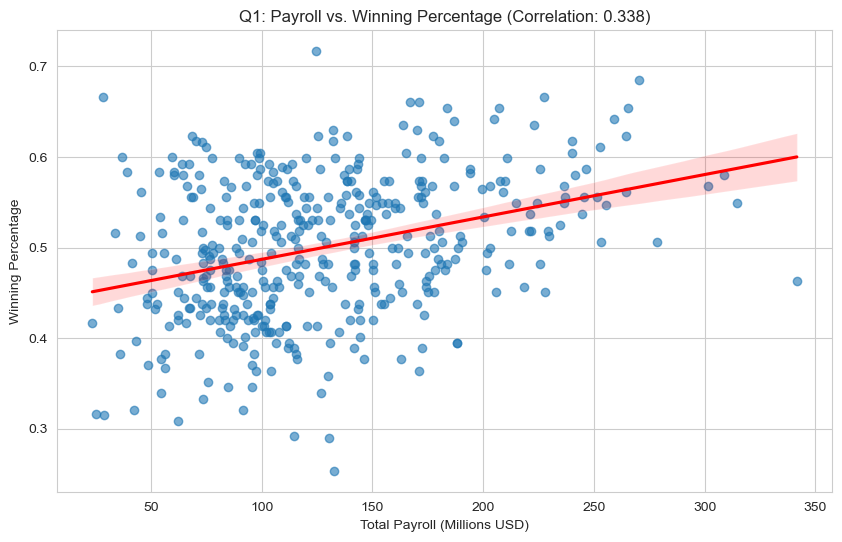

In [2]:
# Calculate correlation coefficient
payroll_mil = df['Payroll'] / 1_000_000
correlation, p_value = pearsonr(payroll_mil, df['Winning_Percentage'])

print(f"Pearson Correlation (Payroll vs. WP): {correlation:.3f}")

# Plotting Q1
plt.figure(figsize=(10, 6))
sns.regplot(x=payroll_mil, y=df['Winning_Percentage'], scatter_kws={'alpha':0.6}, line_kws={"color": "red"})
plt.title(f'Q1: Payroll vs. Winning Percentage (Correlation: {correlation:.3f})')
plt.xlabel('Total Payroll (Millions USD)')
plt.ylabel('Winning Percentage')
plt.savefig('q1_payroll_vs_win_pct.png')
plt.show()

Average CPW (Playoff Teams): $1.66 Million
Average CPW (Non-Playoff Teams): $1.68 Million
Minimum CPW (Playoff Teams): $0.50 Million
Minimum CPW (Non-Playoff Teams): $0.54 Million
Maximum CPW (Playoff Teams): $3.54 Million
Maximum CPW (Non-Playoff Teams): $4.56 Million


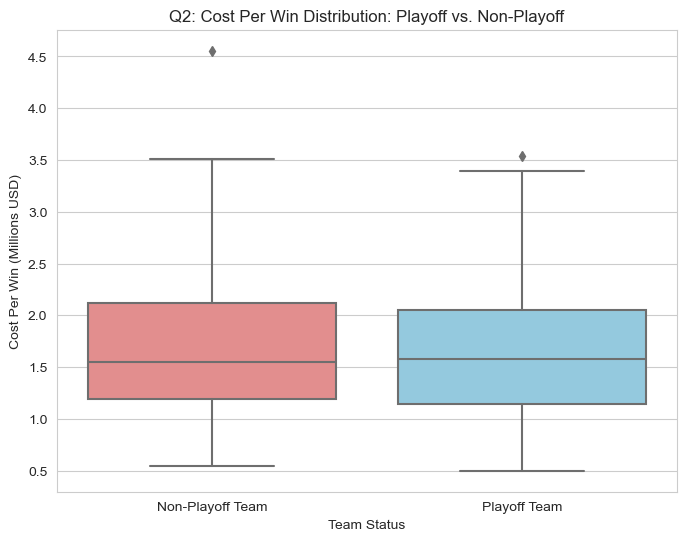

In [3]:
# Calculate Cost Per Win (in millions USD)
df['Cost_Per_Win'] = df['Payroll'] / df['Wins'] / 1_000_000
avg_cpw_playoff = df[df['Playoffs'] == 1]['Cost_Per_Win'].mean()
avg_cpw_non_playoff = df[df['Playoffs'] == 0]['Cost_Per_Win'].mean()
min_cpw_playoff = df[df['Playoffs'] ==1]['Cost_Per_Win'].min()
min_cpw_non_playoff = df[df['Playoffs'] == 0]['Cost_Per_Win'].min()
max_cpw_playoff = df[df['Playoffs'] ==1]['Cost_Per_Win'].max()
max_cpw_non_playoff = df[df['Playoffs'] == 0]['Cost_Per_Win'].max()


print(f"Average CPW (Playoff Teams): ${avg_cpw_playoff:.2f} Million")
print(f"Average CPW (Non-Playoff Teams): ${avg_cpw_non_playoff:.2f} Million")
print(f"Minimum CPW (Playoff Teams): ${min_cpw_playoff:.2f} Million")
print(f"Minimum CPW (Non-Playoff Teams): ${min_cpw_non_playoff:.2f} Million")
print(f"Maximum CPW (Playoff Teams): ${max_cpw_playoff:.2f} Million")
print(f"Maximum CPW (Non-Playoff Teams): ${max_cpw_non_playoff:.2f} Million")

# Plotting Q2
plt.figure(figsize=(8, 6))
sns.boxplot(
    x=df['Playoffs'].map({1: 'Playoff Team', 0: 'Non-Playoff Team'}),
    y=df['Cost_Per_Win'],
    palette={'Playoff Team': 'skyblue', 'Non-Playoff Team': 'lightcoral'}
)
plt.title('Q2: Cost Per Win Distribution: Playoff vs. Non-Playoff')
plt.xlabel('Team Status')
plt.ylabel('Cost Per Win (Millions USD)')
plt.savefig('q2_cost_per_win_boxplot.png')
plt.show()

/var/folders/w7/s3qw9d6903z7pn_fvrj2yk1c0000gn/T/ipykernel_9887/30254972.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ws_by_tier = df.groupby('Payroll_Tier')['WS_Winner'].agg(['count', 'sum'])
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


                    Total_Teams  WS_Wins  WS_Win_Rate
Payroll_Tier                                         
Top 10 Spenders             140        0          0.0
Middle 10 Spenders          140        0          0.0
Bottom 10 Spenders          140        0          0.0


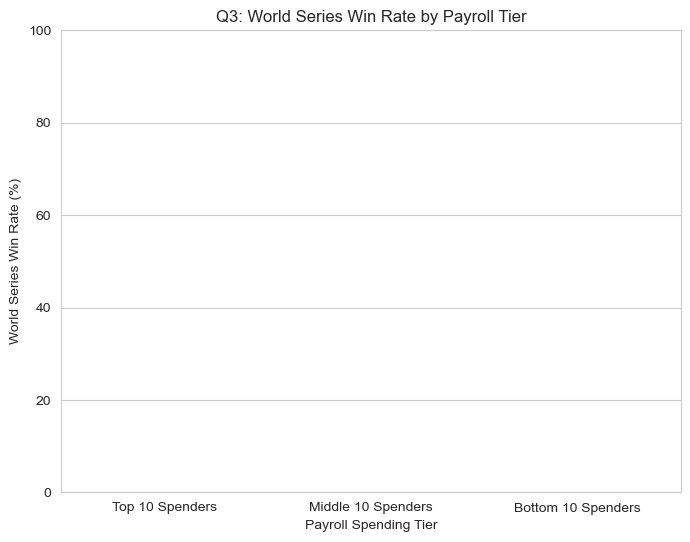

In [4]:
# Define payroll rank and tiers (Top 10, Middle 10, Bottom 10)
df['Payroll_Rank'] = df.groupby('Year')['Payroll'].rank(method='average', ascending=False)
df['Payroll_Tier'] = pd.cut(df['Payroll_Rank'], 
                            bins=[0, 10.5, 20.5, 30.5], 
                            labels=['Top 10 Spenders', 'Middle 10 Spenders', 'Bottom 10 Spenders'], 
                            right=True)

# Calculate WS Winner frequency by tier
ws_by_tier = df.groupby('Payroll_Tier')['WS_Winner'].agg(['count', 'sum'])
ws_by_tier.columns = ['Total_Teams', 'WS_Wins']
ws_by_tier['WS_Win_Rate'] = (ws_by_tier['WS_Wins'] / ws_by_tier['Total_Teams']) * 100

print(ws_by_tier)

# Plotting Q3
plt.figure(figsize=(8, 6))
sns.barplot(x=ws_by_tier.index, y='WS_Win_Rate', data=ws_by_tier, palette='viridis')
plt.title('Q3: World Series Win Rate by Payroll Tier')
plt.xlabel('Payroll Spending Tier')
plt.ylabel('World Series Win Rate (%)')
plt.ylim(0, 100)
plt.savefig('q3_ws_win_rate_by_payroll.png')
plt.show()

In [5]:
# Calculate correlation for Talent vs. Winning Percentage
talent_corr, p_value_talent = pearsonr(df['Talent_OPS_Plus'], df['Winning_Percentage'])

correlations = pd.DataFrame({
    'Predictor': ['Total Payroll', 'Team Talent (Avg OPS+)'],
    'Correlation_R': [correlation, talent_corr]
})
correlations['Correlation_R'] = correlations['Correlation_R'].round(3)

print("\n--- Correlation with Winning Percentage ---")
print(correlations)


--- Correlation with Winning Percentage ---
                Predictor  Correlation_R
0           Total Payroll          0.338
1  Team Talent (Avg OPS+)          0.664
